In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# 目的
遺伝子学的分類に基づいた、予後の2値分類を実施する。  
分類はCLAUDIN_SUBTYPEに基づいて実施。  
予後は5年、10年、15年の3つの年次に分けている。Trueで死亡であることに注意すること。

# データ読み込み
読み込み元：
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/claudin_subtype_chi2"

サブタイプ毎のデータを使用 

In [14]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

# 単一グル―プでのモデルのトレーニング

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [3]:
def validate_models(
    columns_selection_type: str,
    method: str,
):
    for year in range(15, 16, 5):  # 予後年数毎のループ
        prognosis_Xlabel = "X{0:0=2}".format(year)
        prognosis_ylabel = "y{0:0=2}".format(year)

        # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
        X_train = X_dict[columns_selection_type][method]["train"][prognosis_Xlabel]
        y_train = y_dict[columns_selection_type][method]["train"][prognosis_ylabel]
        X_val = X_dict[columns_selection_type][method]["val"][prognosis_Xlabel]
        y_val = y_dict[columns_selection_type][method]["val"][prognosis_ylabel]

        # accuracyの表示
        print("----------" * 10)
        print("予後年数：{0:0=2}年:".format(year))
        if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
            )
        else:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.ones(len(y_train))), 3),
            )
        print("accuracyベースライン：", score)
        print("使用特徴量：", X_train.columns)
        print("学習サンプルサイズ：", X_train.shape)
        display("ラベル比率：", y_train.value_counts())
        save_dir = (
            config.TABLES_MODELS_PROGNOSIS_CROSS_DIR
            + "/scores_base-model/{0}/{1}".format(columns_selection_type, method)
        )
        make_dir(save_dir)
        sm = SMOTE(random_state=SEED)
        display(
            compare_bcms(
                X_train,
                y_train,
                X_val,
                y_val,
                over_sampling_class=sm,
                save_path=save_dir + "/{0:0=2}.csv".format(year),
            )
        )

In [5]:
for k in X_dict.keys():
    print(k)
    validate_models(columns_selection_type=k, method="mrmr")
    validate_models(columns_selection_type=k, method="boruta")

mrna_agilent_microarray_zscores_ref_all_samples
----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'PFN4', 'NACAP1', 'RAPGEF5', 'EMR3', 'CXorf57', 'DNAJB7',
       'ENC1', 'PCM1', 'KRTAP12-4', 'STAT5B', 'AI659947', 'TOR1B', 'BP432397',
       'RNU11', 'UHRF1', 'RBBP8', 'USP30', 'AK022229', 'FGF13', 'BE858513',
       'HS3ST1', 'DFNB59', 'GAL3ST4', 'AURKA', 'DB341438', 'C9orf95', 'S100P',
       'ANKAR', 'WDR67', 'GABRB1', 'AW572907', 'HIST1H2BF', 'APLN', 'GTPBP5'],
      dtype='object')
学習サンプルサイズ： (865, 35)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:00, 11.23it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,0.847072,0.649485,0.848550,0.696429
Logistic Regression,0.786334,0.597938,0.786566,0.642202
Decision Tree,0.821041,0.608247,0.827225,0.634615
Random Forest,0.868764,0.597938,0.869189,0.628571
Linear SVM,0.789588,0.577320,0.789130,0.616822
Sigmoid SVM,0.739696,0.577320,0.736264,0.616822
Quadratic Discriminant Analysis,0.831887,0.587629,0.824859,0.600000
RBF SVM,0.900217,0.556701,0.898455,0.598131
Naive Bayes,0.739696,0.546392,0.737418,0.576923


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['PHF7', 'MKI67', 'ANKAR', 'CDCA5', 'FAM83D', 'MELK', 'MYOM1', 'DLGAP5',
       'AK001020', 'OBFC2B',
       ...
       'AURKB', 'STAT5B', 'MTMR9', 'ZNF232', 'ENC1', 'C7orf63', 'VEGFC',
       'CEP55', 'CIRBP', 'MCM10'],
      dtype='object', length=127)
学習サンプルサイズ： (865, 127)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:02,  5.16it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,0.855748,0.639175,0.854326,0.660194
Quadratic Discriminant Analysis,0.988069,0.556701,0.987978,0.644628
Polynomial SVM,0.943601,0.618557,0.942478,0.626263
Nearest Neighbors,0.766811,0.618557,0.752018,0.618557
Random Forest,0.865510,0.597938,0.867238,0.613861
Logistic Regression,0.808026,0.577320,0.805281,0.609524
Naive Bayes,0.682213,0.587629,0.691903,0.607843
Decision Tree,0.823210,0.567010,0.823402,0.596154
Sigmoid SVM,0.639913,0.536082,0.640693,0.579439


mrna_agilent_microarray
----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'SNX24', 'TUB', 'ARRDC3', 'STAT5B', 'PTPLAD1', 'RBBP8',
       'ENC1', 'RNU11', 'UHRF1', 'PPIL3', 'S100P', 'MST1', 'WARS2', 'FGF13',
       'C9orf95', 'WDR67', 'CBX7', 'INTS10', 'SPATA18', 'HIST1H2BF', 'AURKA',
       'TFPT', 'LRRC50', 'PDK3', 'IGDCC4', 'FGD3', 'AK3', 'LRRC48', 'PSTPIP2',
       'PKMYT1', 'CATSPERB', 'TMEM26', 'STAT5A', 'CCT6B'],
      dtype='object')
学習サンプルサイズ： (865, 35)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:03,  3.39it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.536082,0.666667,0.697987
Polynomial SVM,0.878525,0.649485,0.876923,0.666667
AdaBoost,0.804772,0.618557,0.804348,0.647619
Random Forest,0.847072,0.628866,0.851109,0.647059
Quadratic Discriminant Analysis,0.801518,0.639175,0.796440,0.646465
Linear SVM,0.755965,0.628866,0.754098,0.640000
Naive Bayes,0.733189,0.618557,0.735484,0.633663
Logistic Regression,0.747289,0.608247,0.745911,0.620000
RBF SVM,0.763557,0.587629,0.763043,0.607843


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['CDCA5', 'FAM83D', 'MELK', 'OBFC2B', 'CASC1', 'N4BP2L1', 'AK3',
       'KIF20A', 'OGT', 'AHSA2',
       ...
       'ZNF232', 'OIP5', 'CATSPERB', 'ENC1', 'C7orf63', 'VEGFC', 'MYB',
       'CEP55', 'CIRBP', 'MCM10'],
      dtype='object', length=108)
学習サンプルサイズ： (865, 108)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:09,  1.15it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.536082,0.666667,0.697987
Logistic Regression,0.785249,0.649485,0.781938,0.679245
Decision Tree,0.831887,0.649485,0.832794,0.673077
Quadratic Discriminant Analysis,0.973970,0.628866,0.973510,0.672727
Linear SVM,0.793926,0.639175,0.787946,0.666667
RBF SVM,0.771150,0.618557,0.773362,0.647619
Nearest Neighbors,0.766811,0.618557,0.752589,0.633663
Random Forest,0.866594,0.597938,0.868167,0.628571
AdaBoost,0.842733,0.608247,0.845251,0.627451


mrna_agilent_microarray_zscores_ref_diploid_samples
----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'CYP2D6', 'PTX4', 'BIK', 'ENC1', 'DENND6A', 'STAT5B',
       'RNU11', 'DNAJB7', 'PPIL3', 'UHRF1', 'RBBP8', 'MIR137HG', 'GABRB1',
       'TOR1B', 'MST1', 'NMRK1', 'FGF13', 'HIST1H2BF', 'SPATA4', 'TBC1D31',
       'USP30', 'S100P', 'APLN', 'MTG2', 'GAL3ST4', 'FGD3', 'PJVK', 'INTS10',
       'CBX7', 'FCN2', 'RNASE9', 'SPATA18', 'ANKAR', 'SULT4A1'],
      dtype='object')
学習サンプルサイズ： (865, 35)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:01, 10.81it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Logistic Regression,0.765727,0.670103,0.765727,0.698113
RBF SVM,0.877440,0.670103,0.877040,0.692308
Linear SVM,0.770065,0.649485,0.770065,0.673077
AdaBoost,0.836226,0.639175,0.834973,0.666667
Sigmoid SVM,0.697397,0.649485,0.699677,0.666667
Random Forest,0.859002,0.639175,0.860515,0.653465
Nearest Neighbors,0.814534,0.618557,0.803674,0.647619
Quadratic Discriminant Analysis,0.815618,0.618557,0.805492,0.626263
Naive Bayes,0.748373,0.608247,0.745055,0.620000


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['PHF7', 'MKI67', 'ANKAR', 'CDCA5', 'FAM83D', 'MELK', 'NLRX1', 'CASC1',
       'N4BP2L1', 'PJVK',
       ...
       'WDR19', 'RBBP8', 'SLC38A10', 'RSRC1', 'STAT5B', 'ZNF232', 'TRNP1',
       'ENC1', 'CEP55', 'MCM10'],
      dtype='object', length=116)
学習サンプルサイズ： (865, 116)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:03,  2.82it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.978308,0.608247,0.977974,0.688525
Decision Tree,0.817787,0.618557,0.822410,0.660550
Nearest Neighbors,0.765727,0.659794,0.746479,0.637363
RBF SVM,0.873102,0.618557,0.870144,0.626263
Sigmoid SVM,0.646421,0.587629,0.644105,0.622642
AdaBoost,0.850325,0.639175,0.849345,0.615385
Linear SVM,0.795011,0.577320,0.793443,0.594059
Logistic Regression,0.797180,0.577320,0.796074,0.594059
Naive Bayes,0.689805,0.597938,0.698312,0.589474


### 予測モデル、特徴量数、年数毎の比較

In [13]:
def model2result_list(
    clf: callable,
    X_train: pd.DataFrame(),
    y_train: pd.DataFrame(),
    X_test: pd.DataFrame(),
    y_test: pd.DataFrame(),
    model_name: str,
    year: int,
    k: int,
) -> list():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return [year, model_name, acc, pre, rec, f1, k]

In [14]:
row = []
fold = 5
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0:0=2}".format(year)
    prognosis_ylabel = "y{0:0=2}".format(year)
    for k in range(10, 51, 10):
        tmp = None
        X = X_dict["genes"]["boruta"]["train"][prognosis_Xlabel]
        y = y_dict["genes"]["boruta"]["train"][prognosis_ylabel]

        skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=SEED)
        for train_index, val_indes in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_indes]
            y_train, y_val = y.iloc[train_index], y.iloc[val_indes]

            assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
            assert X_val.shape[0] == y_val.shape[0], "test size is incorrect"

            # 特徴量選択の実施（mRMR）
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=k,
                show_progress=False,
            )

            # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
            # list変換するのはfuture warningが出るため
            X_train = X_train[features]
            X_val = X_val[features]

            # スケーリングの実施
            X_train, X_val = transform_std(X_train, X_val)
            # X_train, X_val = transform_norm(X_train, X_val)

            # サンプリングの実装
            # positive_count_train = y_train.value_counts().sort_values()[0]
            rus = RandomUnderSampler(sampling_strategy="all", random_state=SEED)
            # smote = SMOTE(sampling_strategy="all", random_state=SEED)
            X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

            # accuracyの表示
            """
            print("予後年数：{0:0=2}年:".format(year))
            print("学習サンプルサイズ：", X_train.shape)
            display("ラベル比率：", y_train.value_counts())        
            """

            # ここからモデルのtrain、x軸をkとしたacc, f1の推移plot
            # print("Random Forest")
            params = {
                "n_estimators": 500,
                "criterion": "entropy",
                "max_depth": 5,
                "max_leaf_nodes": 20,
                "max_features": "log2",
                "class_weight": "balanced",
                "random_state": SEED,
            }
            rf = RandomForestClassifier(**params)
            tmp = model2result_list(rf, X_train, y_train, X_val, y_val, "rf", year, k)
            row.append(tmp)

            # print("Logistic Regression")
            params = {
                "penalty": "l2",
                "C": 0.5,
                "solver": "saga",
                "class_weight": "balanced",
            }
            lr = LogisticRegression(**params)
            tmp = model2result_list(lr, X_train, y_train, X_val, y_val, "lr", year, k)
            row.append(tmp)

            # print("Support Vector Machine")
            params = {
                "C": 50,
                "kernel": "sigmoid",
                "decision_function_shape": "ovr",
                "class_weight": "balanced",
            }
            svm = SVC(**params)
            tmp = model2result_list(svm, X_train, y_train, X_val, y_val, "svm", year, k)
            row.append(tmp)

    # 結果をdfにまとめている
    df_result = pd.DataFrame(
        row,
        columns=[
            "year",
            "model_name",
            "acc",
            "precision",
            "recall",
            "f1",
            "feature size",
        ],
    )

100%|███████████████████████████████████████████████████████████████████████████| 3/3 [04:02<00:00, 80.77s/it]


In [15]:
df_result[df_result["model_name"] == "rf"].groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
5    20            0.775649   0.436279  0.629167  0.513414
     40            0.770243   0.425795  0.629167  0.506297
     10            0.769462   0.428691  0.650000  0.514431
     30            0.768690   0.424342  0.633333  0.506838
     50            0.768687   0.424907  0.637500  0.508714
10   10            0.725892   0.611345  0.647612  0.628050
     40            0.719143   0.596486  0.661237  0.626919
     50            0.719143   0.596486  0.661237  0.626919
     30            0.718186   0.595029  0.666679  0.628448
     20            0.715282   0.591565  0.661163  0.623962
15   40            0.700804   0.715520  0.734118  0.724235
     30            0.696983   0.715007  0.724706  0.719471
     50            0.695725   0.708438  0.736471  0.721737
     20            0.689396   0.711467  0.708235  0.709266
     10            0.666699   0.698903  0.672941  0.682305

## 最適な特徴量数はいくつなのか実験

特徴量選択数を変化させ、学習曲線を描画する

### chi2

In [9]:
"""
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)

    for k in range(min_k, max_k + 1, span):
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        result_chi2 = feature_selection(X_train, y_train, chi2, "k_best", k)
        features = list(result_chi2[result_chi2["False: dropped"]].index)
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, k // span - 1],
            ylim=(0.49, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/chi2")
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/chi2/X{0:0=2}.png".format(year)
    )
"""
pass

### mrmr

  0%|                                                                                   | 0/3 [00:00<?, ?it/s]

train_acc_mean:  [0.99913793 0.91299735 0.87261346 0.84528302 0.8288908 ]
test_acc_mean:  [0.80692308 0.79230769 0.77923077 0.76       0.76538462]
train_f1_mean:  [0.99818182 0.79829049 0.71648862 0.6659134  0.64261644]
test_f1_mean:  [0.33324319 0.46928442 0.48826697 0.47800129 0.50617197]
train_acc_mean:  [0.99913793 0.94350133 0.90375587 0.87047725 0.84840929]
test_acc_mean:  [0.82923077 0.79923077 0.78538462 0.76846154 0.77307692]
train_f1_mean:  [0.99818182 0.86404567 0.77465641 0.7106564  0.67418731]
test_f1_mean:  [0.34057818 0.44811471 0.48664395 0.47895341 0.50637573]
train_acc_mean:  [0.99913793 0.94960212 0.90688576 0.87591565 0.85313844]
test_acc_mean:  [0.82       0.80153846 0.78230769 0.77230769 0.76846154]
train_f1_mean:  [0.99818182 0.87652561 0.78169346 0.72057972 0.68286204]
test_f1_mean:  [0.30541082 0.45185107 0.47808561 0.48901178 0.50317462]
train_acc_mean:  [0.99913793 0.95331565 0.91032864 0.87314095 0.85004299]
test_acc_mean:  [0.82153846 0.80076923 0.78       

 33%|████████████████████████▋                                                 | 1/3 [08:36<17:12, 516.38s/it]

train_acc_mean:  [0.98817204 0.89966887 0.84804687 0.8166205  0.80085837]
test_acc_mean:  [0.71442308 0.69326923 0.7125     0.7125     0.70288462]
train_f1_mean:  [0.98266255 0.85393818 0.78118774 0.74358981 0.72434475]
test_f1_mean:  [0.54347648 0.55423253 0.58967167 0.60452934 0.59665823]
train_acc_mean:  [1.         0.94006623 0.88320312 0.85498615 0.83948498]
test_acc_mean:  [0.725      0.73461538 0.72692308 0.73269231 0.74038462]
train_f1_mean:  [1.         0.91337891 0.83372624 0.79760462 0.77967452]
test_f1_mean:  [0.53899891 0.60044612 0.6051004  0.62901439 0.64434435]
train_acc_mean:  [1.         0.94370861 0.88574219 0.85138504 0.82854077]
test_acc_mean:  [0.72403846 0.74423077 0.74326923 0.74134615 0.74903846]
train_f1_mean:  [1.         0.91993519 0.84015911 0.79782215 0.77238966]
test_f1_mean:  [0.53240281 0.62534066 0.63764295 0.64740199 0.66086892]
train_acc_mean:  [1.         0.95761589 0.90527344 0.86814404 0.84624464]
test_acc_mean:  [0.73461538 0.74615385 0.75576923 

 67%|█████████████████████████████████████████████████▎                        | 2/3 [16:51<08:23, 503.63s/it]

train_acc_mean:  [1.         0.91471861 0.86905371 0.83829401 0.80533708]
test_acc_mean:  [0.67625 0.68125 0.67875 0.68625 0.685  ]
train_f1_mean:  [1.         0.92146129 0.87776981 0.84548836 0.81168617]
test_f1_mean:  [0.70792683 0.70808085 0.69846123 0.70104531 0.70060257]
train_acc_mean:  [1.         0.94675325 0.90460358 0.86787659 0.84424157]
test_acc_mean:  [0.6925  0.71125 0.71375 0.715   0.71875]
train_f1_mean:  [1.         0.95077879 0.91111164 0.87497214 0.85144457]
test_f1_mean:  [0.71899052 0.7359715  0.73389328 0.73553575 0.73704792]
train_acc_mean:  [1.         0.95584416 0.91150895 0.88330309 0.85337079]
test_acc_mean:  [0.69625 0.71    0.70875 0.7175  0.71625]
train_f1_mean:  [1.         0.95917405 0.91764201 0.88920241 0.86065003]
test_f1_mean:  [0.73025038 0.73415966 0.73226204 0.74120654 0.73846828]
train_acc_mean:  [1.         0.97229437 0.9258312  0.8907441  0.86544944]
test_acc_mean:  [0.6975  0.70375 0.6975  0.68875 0.7075 ]
train_f1_mean:  [1.         0.9743714

100%|██████████████████████████████████████████████████████████████████████████| 3/3 [24:44<00:00, 494.80s/it]


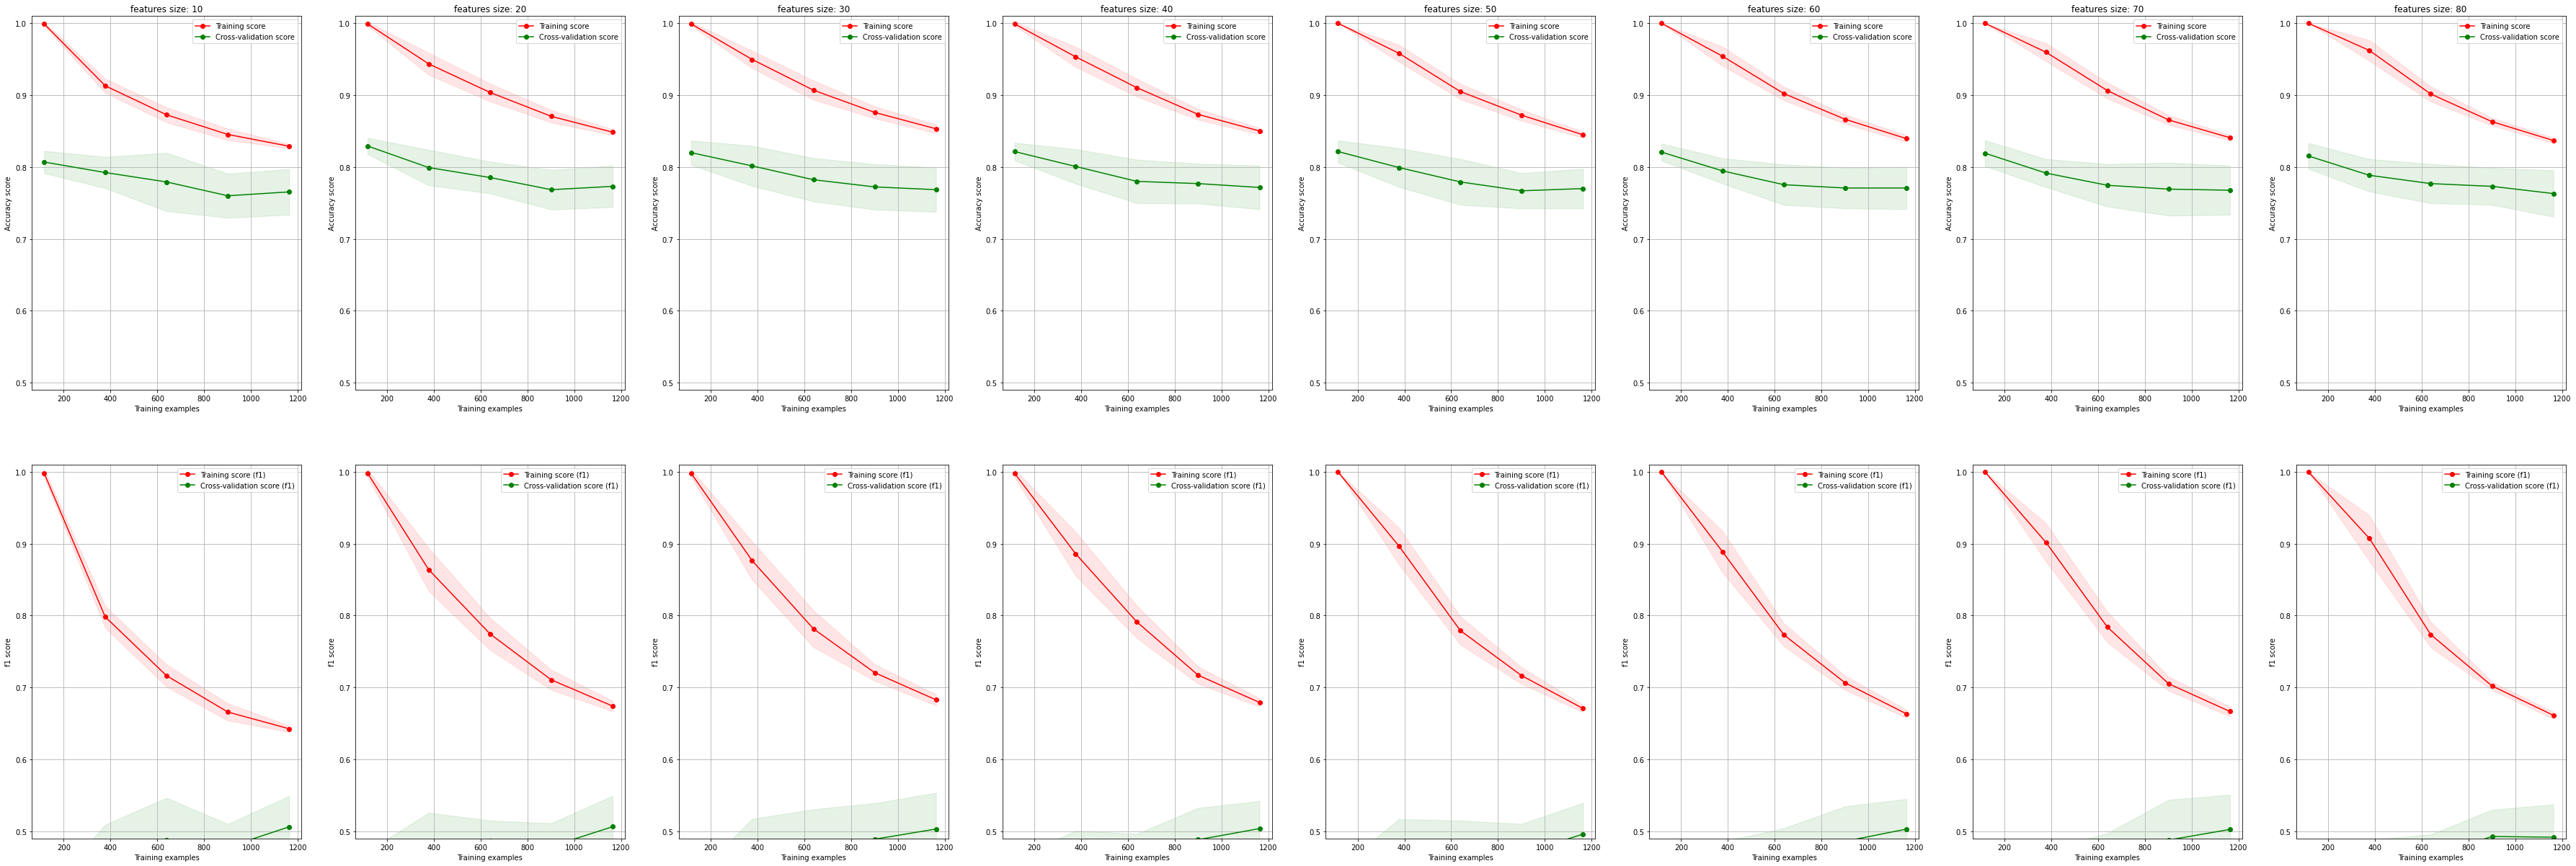

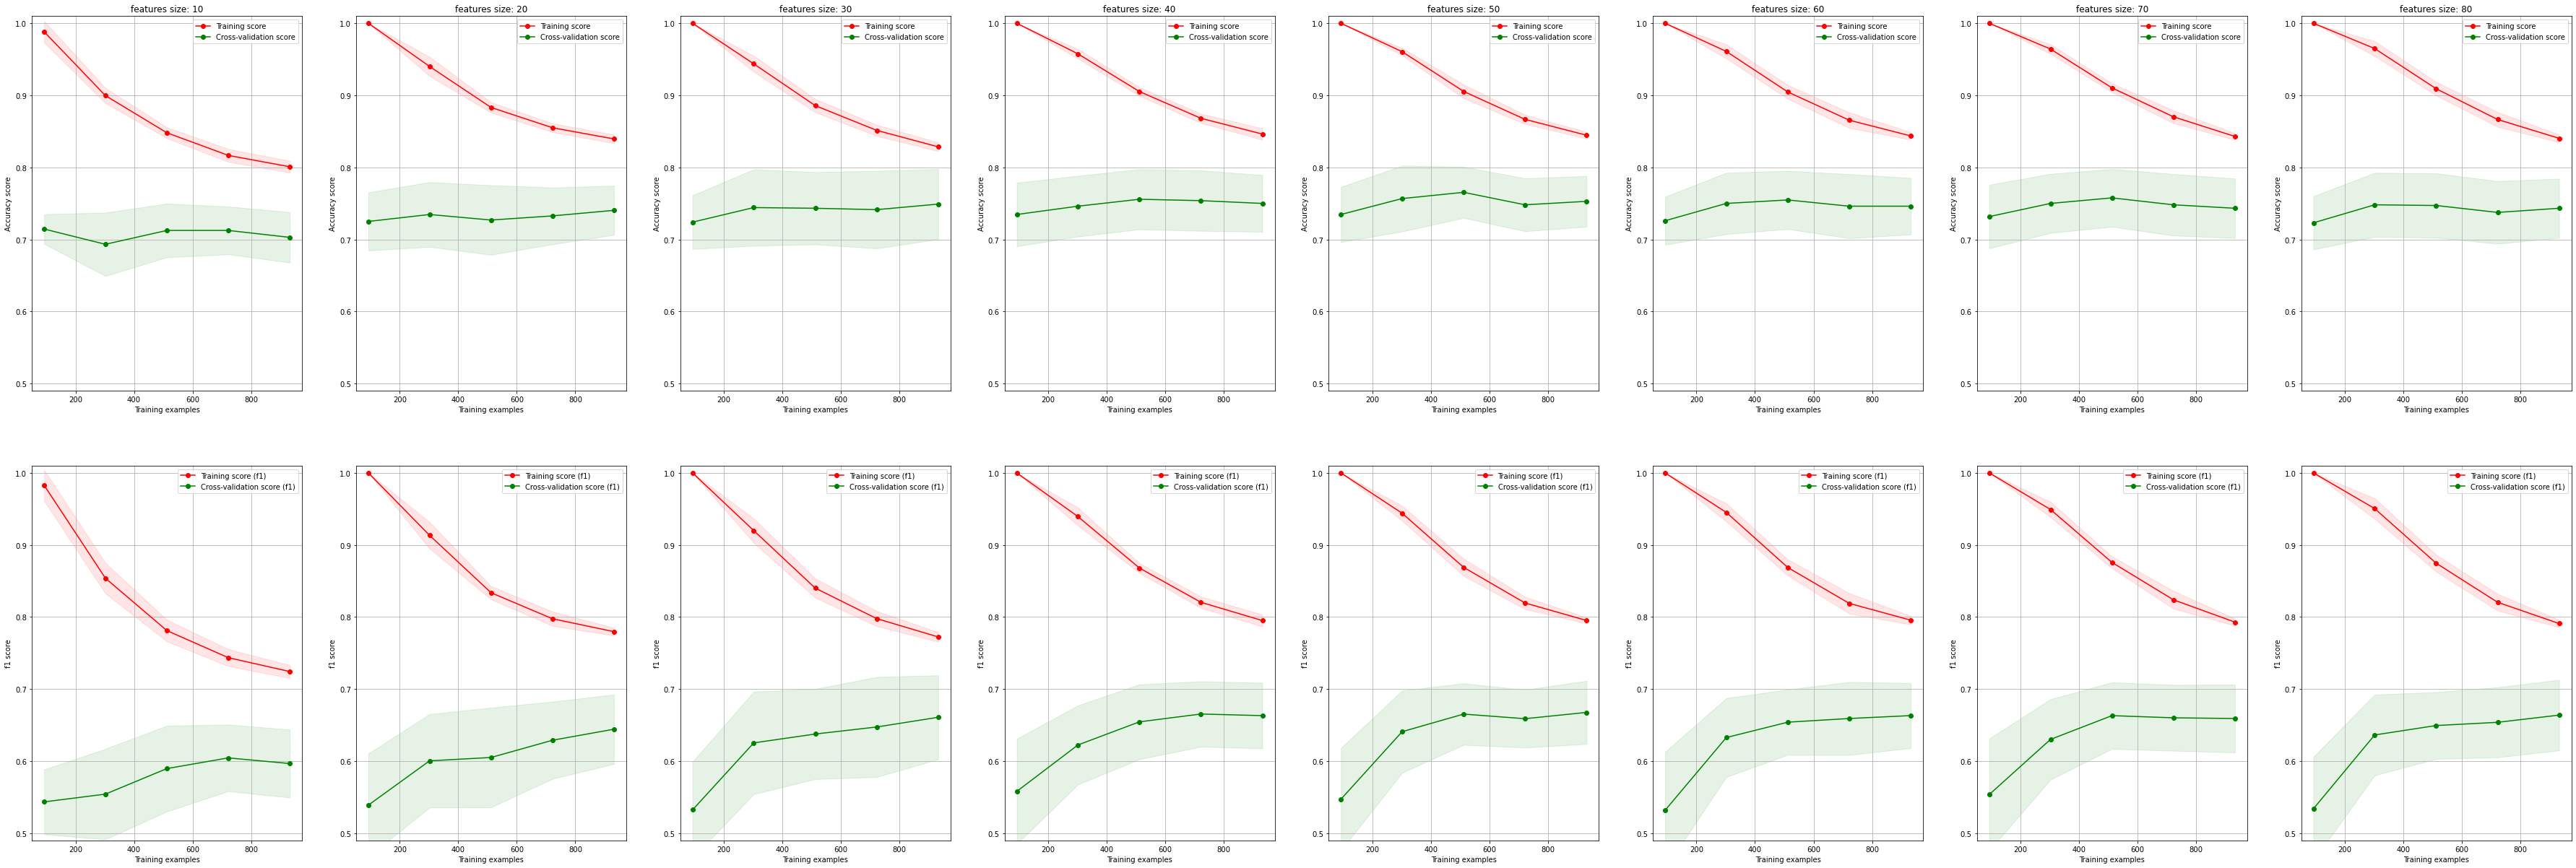

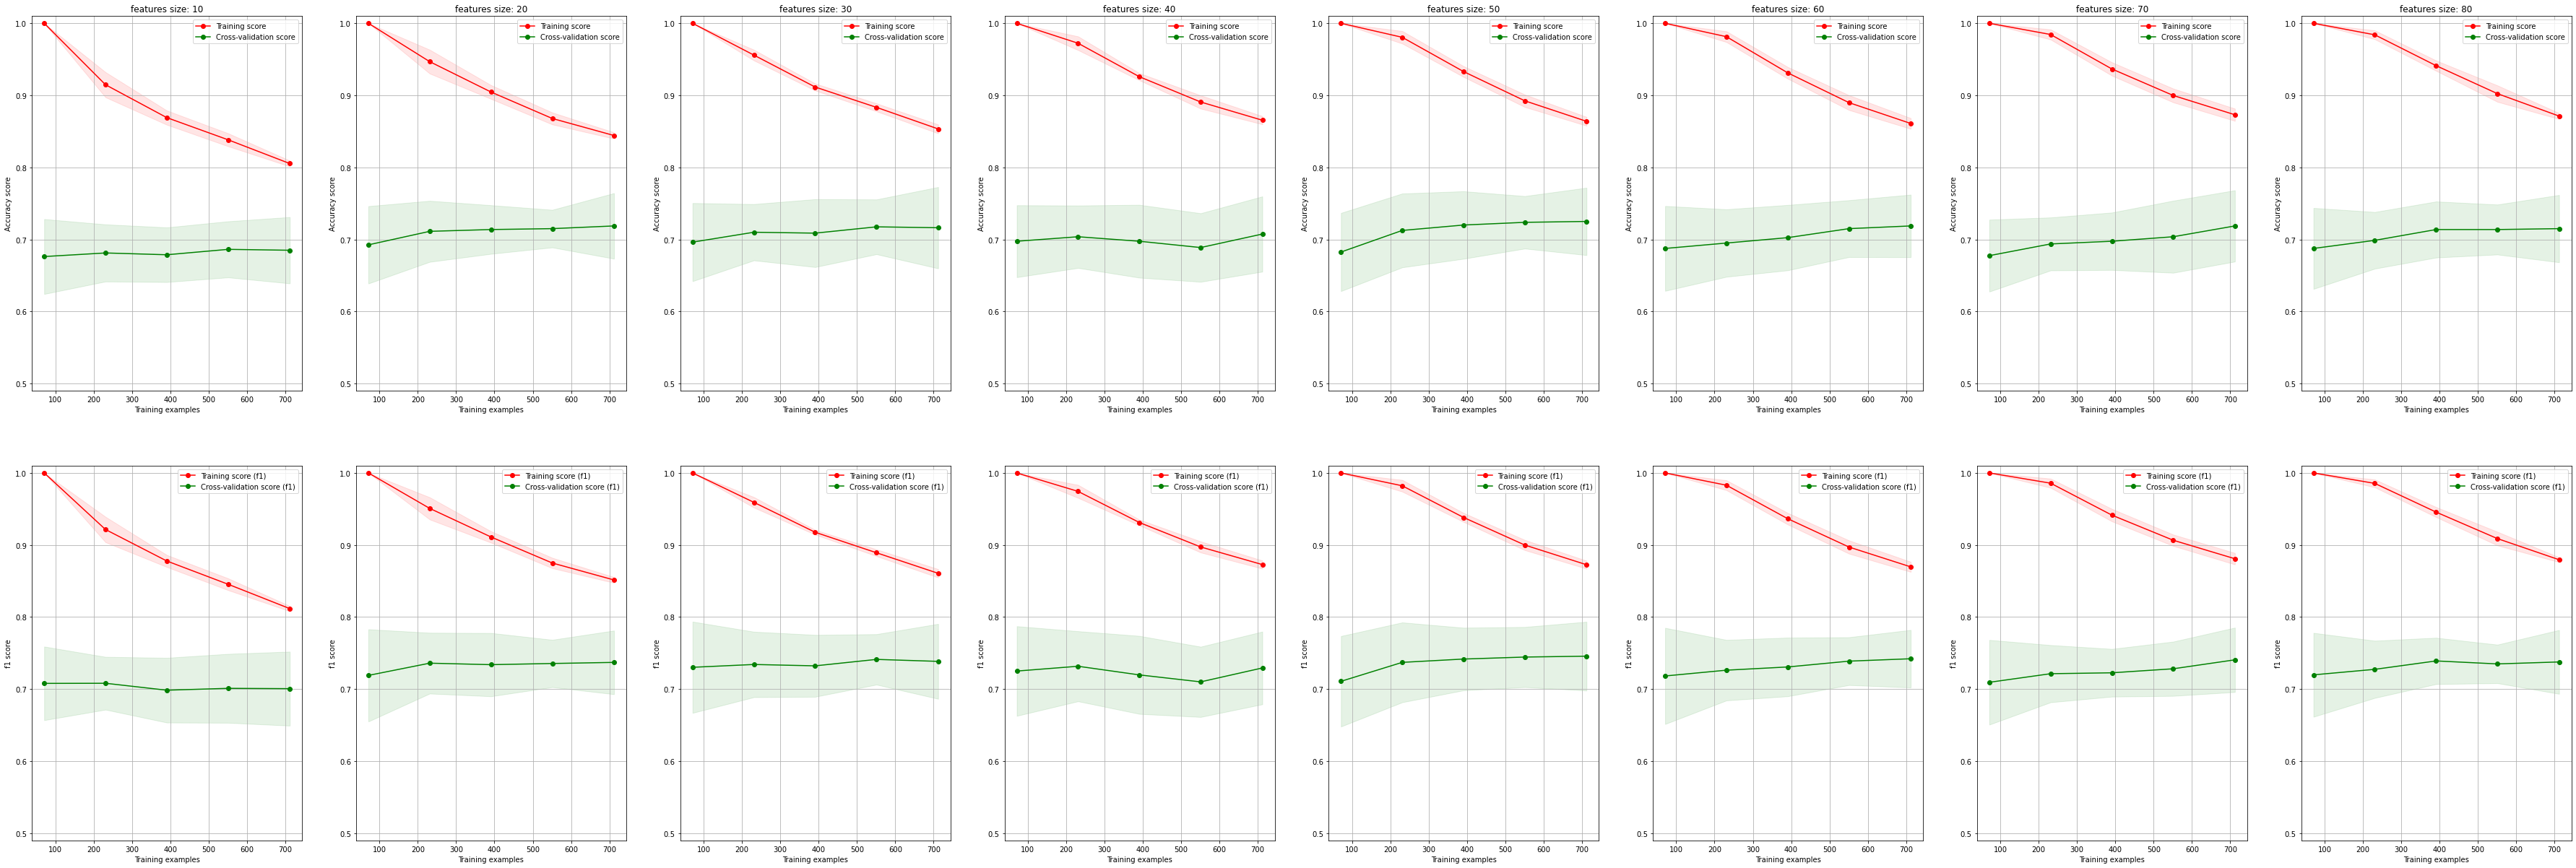

In [19]:
"""
for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)

    for k in range(min_k, max_k + 1, span):
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        features = mrmr.mrmr_classif(
            X=X_train,
            y=y_train,
            K=k,
            show_progress=False,
        )
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, (k - min_k) // span],
            ylim=(0.49, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/mrmr")
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/mrmr/X{0:0=2}.png".format(year)
    )
"""
pass

### boruta

In [11]:
"""
warnings.simplefilter("ignore")

for year in tqdm(range(5, 16, 5)):  # 予後年数毎のループ
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 80
    span = 10
    fig, axes = plt.subplots(2, (max_k - min_k) // span + 1, figsize=(63, 21))
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)
    print("year:", year)

    for k in range(min_k, max_k + 1, span):
        print("-----" * 10)
        print("k num: ", k)
        # 特徴量選択するために、trainのデータを抽出
        X_train, _, y_train, _ = train_test_split(X, y, random_state=SEED, stratify=y)
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"

        # RandomForestClassifierでBorutaを実行
        rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=SEED)
        feat_selector = BorutaPy(rf, n_estimators="auto", verbose=0, random_state=SEED)
        feat_selector.fit(
            X_train.values,
            y_train.values,
        )
        # 選択された特徴量を確認
        print(len(X_train.columns[feat_selector.support_]))
        features = X_train.columns[feat_selector.support_][:k]

        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, k // span - 1],
            ylim=(0.59, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/boruta")
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/boruta/X{0:0=2}.png".format(year)
    )
"""
pass

## 詳細な絞り込み

学習曲線上ではtarinとtestの差がデータ数を増やしても劇的に減るわけではなかった  
→データ数を増やすのはあまり効果がない？

mrmrは20付近がf1が高く、かつ特徴量数が少なくて済んでいる

特徴量選択時のリークをなくし、精度を見ていく

In [12]:
"""
warnings.simplefilter("ignore")

for year in tqdm(range(15, 16, 5)):  # 予後年数毎のループ（時間の都合上、15のみ実験）
    # 特徴量選択から行うので特徴量選択前のデータから使用
    X_train = X_dict["basic"]["train"]["X{0:0=2}".format(year)]
    y_train = y_dict["basic"]["train"]["y{0:0=2}".format(year)]
    min_k = 10
    max_k = 30
    span = 1
    fig, axes = plt.subplots(
        2, (max_k - min_k) // span + 1, figsize=(22 * (max_k - min_k // span + 1), 22)
    )
    cv = StratifiedShuffleSplit(n_splits=10, random_state=SEED)
    print("year:", year)

    for k in range(min_k, max_k + 1, span):
        print("-----" * 10)
        print("k num: ", k)
        # 特徴量選択するために、trainのデータを抽出
        X_t, _, y_t, _ = train_test_split(
            X_train, y_train, random_state=SEED, stratify=y_train
        )
        assert X_t.shape[0] == y_t.shape[0], "train size is incorrect"

        features = mrmr.mrmr_classif(
            X=X_t,
            y=y_t,
            K=k,
            show_progress=False,
        )
        title = "features size: {0}".format(len(features))

        params = {
            "n_estimators": 500,
            "criterion": "entropy",
            "max_depth": 5,
            "max_leaf_nodes": 20,
            "max_features": "log2",
            "class_weight": "balanced",
            "random_state": SEED,
        }
        estimator = RandomForestClassifier(**params)

        # cvをplot_learning_curve内で実施するので、X(y)_trainは使用しない
        plot_learning_curve(
            estimator,
            title,
            X[features],
            y,
            axes=axes[:, (k - min_k) // span],
            ylim=(0.59, 1.01),
            cv=cv,
            n_jobs=4,
            scoring="accuracy",
        )
    make_dir(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR + "/learning_curve/basic/mrmr_detail"
    )
    plt.savefig(
        config.FIGURES_MODELS_PROGNOSIS_CROSS_DIR
        + "/learning_curve/basic/mrmr_detail/X{0:0=2}.png".format(year)
    )
"""
pass

# subtype毎のベースライン・学習

In [12]:
def validate_models_subtype(
    columns_selection_type: str,
    method: str,
):
    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    for year in range(15, 16, 5):  # 予後年数毎のループ
        print("====={0:0=2}".format(year) * 10)

        for subtype in subtypes:
            prognosis_Xlabel = "X{0:0=2}_{1}".format(year, subtype)
            prognosis_ylabel = "y{0:0=2}_{1}".format(year, subtype)
            X_train = X_dict[columns_selection_type]["claudin_subtype"][method][
                "train"
            ][prognosis_Xlabel]
            y_train = y_dict[columns_selection_type]["claudin_subtype"][method][
                "train"
            ][prognosis_ylabel]
            X_val = X_dict[columns_selection_type]["claudin_subtype"][method]["val"][
                prognosis_Xlabel
            ]
            y_val = y_dict[columns_selection_type]["claudin_subtype"][method]["val"][
                prognosis_ylabel
            ]
            assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
            assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
            if X_train.shape[1] == 0:
                print(
                    "**--WARNING: FEATURE NUM is 0! -> subtype {0} train is skipped!--**".format(
                        subtype
                    )
                )
                continue

            # accuracyの表示
            print("----------" * 10)
            print("subtype: ", subtype)
            print("予後年数：{0:0=2}年:".format(year))
            if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
                score = (
                    "0>1".format(year),
                    round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
                )
            else:
                score = (
                    "0>1".format(year),
                    round(accuracy_score(y_train, np.ones(len(y_train))), 3),
                )
            print("accuracyベースライン：", score)
            print("使用特徴量：", X_train.columns)
            print("学習サンプルサイズ：", X_train.shape)
            display("ラベル比率：", y_train.value_counts())

            sm = SMOTE(random_state=SEED)
            display(
                compare_bcms(
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    over_sampling_class=sm,
                )
            )

In [13]:
for k in X_dict.keys():
    print(k)
    validate_models_subtype(columns_selection_type=k, method="mrmr")
    validate_models_subtype(columns_selection_type=k, method="boruta")

mrna_agilent_microarray_zscores_ref_all_samples
=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['BF511322', 'BIRC7', 'ZFP90', 'CHRNB3', 'IL34', 'AA939346', 'AW301012',
       'DB341932', 'MRPL53', 'CHDH', 'DA102929', 'GTPBP5', 'BF447974', 'NAV2',
       'C20orf29', 'NCRNA00160', 'PRPSAP1', 'CD511953', 'STX1B', 'COBL'],
      dtype='object')
学習サンプルサイズ： (89, 20)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 41.34it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.83,0.6,0.852174,0.600000
Quadratic Discriminant Analysis,1.00,0.6,1.000000,0.500000
Linear SVM,1.00,0.5,1.000000,0.285714
Logistic Regression,1.00,0.4,1.000000,0.250000
Polynomial SVM,1.00,0.4,1.000000,0.250000
RBF SVM,1.00,0.4,1.000000,0.250000
Sigmoid SVM,0.95,0.4,0.951456,0.250000
Nearest Neighbors,0.95,0.3,0.952381,0.222222
AdaBoost,1.00,0.2,1.000000,0.000000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['OS9', 'BX102680', 'MMP15', 'BCHE', 'OR2M7', 'PSMB11', 'ZIC2',
       'CEACAM3', 'YY2', 'S100P', 'ANGPT2', 'AW243302', 'FPGS', 'FLJ41170',
       'KLK1', 'CDH10', 'IL20RA', 'N90609', 'APOBEC3A', 'C15orf26'],
      dtype='object')
学習サンプルサイズ： (275, 20)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 32.40it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.907514,0.838710,0.903614,0.782609
RBF SVM,0.947977,0.806452,0.947977,0.727273
Sigmoid SVM,0.812139,0.774194,0.811594,0.695652
AdaBoost,0.985549,0.774194,0.985673,0.666667
Logistic Regression,0.890173,0.774194,0.888235,0.666667
Decision Tree,0.829480,0.741935,0.820669,0.636364
Polynomial SVM,0.971098,0.741935,0.970414,0.636364
Naive Bayes,0.841040,0.774194,0.831804,0.631579
Linear SVM,0.872832,0.709677,0.871345,0.571429


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['ENC1', 'AI093492', 'C4orf32', 'SUN1', 'C14orf49', 'CYP2C19',
       'LOC645177', 'TET3', 'CELSR2', 'CR743466', 'LPAR3', 'GPR32', 'TTTY8B',
       'TP53BP2', 'AW118757', 'WDR60', 'MBD3', 'TTC1', 'LRRC50', 'BI481412'],
      dtype='object')
学習サンプルサイズ： (213, 20)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 36.77it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Polynomial SVM,0.967391,0.625000,0.968421,0.727273
Quadratic Discriminant Analysis,0.967391,0.583333,0.967033,0.705882
Random Forest,0.949275,0.583333,0.948529,0.666667
Naive Bayes,0.909420,0.541667,0.905660,0.645161
RBF SVM,0.971014,0.541667,0.970149,0.645161
Decision Tree,0.829710,0.583333,0.815686,0.642857
AdaBoost,1.000000,0.500000,1.000000,0.625000
Logistic Regression,0.945652,0.458333,0.943396,0.580645
Sigmoid SVM,0.905797,0.500000,0.900000,0.571429


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['MICAL1', 'PCSK1N', 'AI797128', 'MGAT4C', 'LINC00307', 'DDX25', 'ACRV1',
       'OR13H1', 'MTTP', 'AW593287', 'AA405052', 'CA449938', 'PPIE_1', 'SETD5',
       'INSC', 'KRTAP21-1', 'LOC441617', 'GRIP1', 'WARS2', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (122, 20)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 38.38it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Polynomial SVM,0.957831,0.785714,0.959538,0.842105
Naive Bayes,0.963855,0.714286,0.964286,0.777778
Quadratic Discriminant Analysis,0.981928,0.714286,0.982249,0.777778
RBF SVM,0.993976,0.642857,0.994012,0.705882
Sigmoid SVM,0.927711,0.642857,0.925926,0.705882
AdaBoost,1.000000,0.642857,1.000000,0.666667
Logistic Regression,0.969880,0.571429,0.970060,0.625000
Random Forest,0.957831,0.571429,0.958084,0.625000
Nearest Neighbors,0.969880,0.500000,0.969325,0.533333


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['KIF13B', 'ZNF833P', 'RNF170', 'T80781', 'SLC25A15', 'ENO4', 'HCN1',
       'Z38762', 'AI797584', 'LOC389033', 'AP2A2', 'ZFAND2A', 'AI745455',
       'TBC1D14', 'JMJD6', 'NT5M', 'RPGRIP1L', 'SPTAN1', 'LOXL4', 'ARSG'],
      dtype='object')
学習サンプルサイズ： (58, 20)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 48.24it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.833333,0.714286,0.825397,0.750000
Naive Bayes,0.969697,0.714286,0.969697,0.750000
Nearest Neighbors,1.000000,0.714286,1.000000,0.750000
Random Forest,0.954545,0.714286,0.953846,0.750000
Quadratic Discriminant Analysis,1.000000,0.571429,1.000000,0.727273
AdaBoost,1.000000,0.571429,1.000000,0.666667
Logistic Regression,1.000000,0.571429,1.000000,0.666667
Polynomial SVM,0.984848,0.571429,0.985075,0.666667
RBF SVM,1.000000,0.571429,1.000000,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：15年:
accuracyベースライン： ('0>1', 0.61)
使用特徴量： Index(['FBXO31', 'AW572907', 'AI939551', 'FAM24A', 'BX099468', 'TUBB3',
       'DB312513', 'OR51I2', 'PAPOLA', 'TRIM77P', 'CXCL13', 'BM676522',
       'STATH', 'HSD3B2', 'NUDT12', 'PTX4', 'CCDC141', 'AW118163', 'AW293618',
       'ELAVL2'],
      dtype='object')
学習サンプルサイズ： (105, 20)


'ラベル比率：'

1    64
0    41
Name: OS_15years, dtype: int64

11it [00:00, 41.23it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.992188,0.583333,0.992126,0.705882
Decision Tree,0.851562,0.500000,0.861314,0.666667
Polynomial SVM,0.992188,0.416667,0.992248,0.588235
Naive Bayes,0.953125,0.333333,0.953125,0.500000
Random Forest,0.976562,0.333333,0.976378,0.500000
AdaBoost,1.000000,0.333333,1.000000,0.428571
Nearest Neighbors,0.906250,0.333333,0.900000,0.428571
Linear SVM,1.000000,0.250000,1.000000,0.400000
Logistic Regression,1.000000,0.250000,1.000000,0.400000


=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['CGNL1', 'AW301012', 'COBL', 'TMEM101', 'ZGLP1', 'ALDH9A1', 'MYO5C',
       'DNASE1', 'ZNF750', 'RHOG', 'THRB', 'SHANK2', 'NAV2', 'BF447974',
       'IL10RB', 'BF511322', 'STX1B', 'DUT', 'GABRA1', 'TMEM231', 'BQ428953'],
      dtype='object')
学習サンプルサイズ： (89, 21)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 40.72it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.83,0.6,0.852174,0.500000
AdaBoost,1.00,0.6,1.000000,0.333333
Sigmoid SVM,0.91,0.4,0.912621,0.250000
Naive Bayes,0.96,0.3,0.960784,0.222222
Linear SVM,0.98,0.5,0.980000,0.000000
Logistic Regression,0.96,0.5,0.960000,0.000000
Nearest Neighbors,0.92,0.5,0.921569,0.000000
Polynomial SVM,0.95,0.6,0.947368,0.000000
Quadratic Discriminant Analysis,0.99,0.4,0.989899,0.000000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['ZIC2', 'RPL5', 'BM713638', 'OS9', 'S100P', 'PIGV', 'RACGAP1', 'GDF5',
       'QARS1', 'PDZK1IP1', 'CXCL14', 'OXSM', 'LSR', 'PEX11G', 'CPSF3',
       'RPUSD2', 'GNL1', 'FPGS', 'AA643892'],
      dtype='object')
学習サンプルサイズ： (275, 19)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 30.95it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.864162,0.774194,0.862170,0.631579
Naive Bayes,0.789017,0.709677,0.787172,0.608696
Sigmoid SVM,0.696532,0.709677,0.690265,0.571429
Polynomial SVM,0.947977,0.741935,0.947059,0.555556
Linear SVM,0.774566,0.709677,0.767857,0.526316
Logistic Regression,0.763006,0.709677,0.761628,0.526316
RBF SVM,0.921965,0.709677,0.923077,0.526316
AdaBoost,0.965318,0.612903,0.965714,0.500000
Nearest Neighbors,0.843931,0.677419,0.851648,0.444444


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['TMEM106B', 'CR743466', 'WDR60', 'CELSR2', 'EYA2', 'FCRLB', 'RNF225',
       'ZNF273', 'BI481412', 'BX102609', 'PRKAR1A', 'ENC1', 'ICA1L'],
      dtype='object')
学習サンプルサイズ： (213, 13)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 41.53it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.826087,0.791667,0.815385,0.848485
Polynomial SVM,0.873188,0.625000,0.885246,0.742857
Decision Tree,0.836957,0.625000,0.835165,0.709677
Random Forest,0.891304,0.583333,0.889706,0.705882
AdaBoost,0.978261,0.500000,0.978102,0.625000
Linear SVM,0.797101,0.500000,0.801418,0.625000
Logistic Regression,0.797101,0.500000,0.801418,0.625000
RBF SVM,0.887681,0.500000,0.888889,0.625000
Naive Bayes,0.764493,0.458333,0.775087,0.580645


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['CA773219', 'NBN', 'CCNJL', 'BU727048'], dtype='object')
学習サンプルサイズ： (122, 4)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 48.93it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,0.783133,0.571429,0.783133,0.666667
Logistic Regression,0.777108,0.571429,0.778443,0.666667
Polynomial SVM,0.849398,0.500000,0.866310,0.666667
Quadratic Discriminant Analysis,0.795181,0.571429,0.806818,0.666667
Random Forest,0.873494,0.571429,0.869565,0.666667
Sigmoid SVM,0.662651,0.571429,0.670588,0.666667
RBF SVM,0.885542,0.500000,0.891429,0.631579
AdaBoost,0.987952,0.428571,0.987952,0.600000
Decision Tree,0.825301,0.428571,0.841530,0.600000


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['DPY19L2', 'SESN1', 'AI912012', 'ENO4', 'C1orf144', 'ARSG', 'JMJD6',
       'SLC30A3', 'NT5M', 'KIF13B', 'AP2A2', 'LOC389033', 'FIGN'],
      dtype='object')
学習サンプルサイズ： (58, 13)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 49.50it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,1.000000,0.857143,1.000000,0.888889
Linear SVM,1.000000,0.857143,1.000000,0.888889
Logistic Regression,1.000000,0.857143,1.000000,0.888889
Naive Bayes,0.924242,0.857143,0.923077,0.888889
Random Forest,0.954545,0.857143,0.953846,0.888889
Sigmoid SVM,0.939394,0.857143,0.937500,0.888889
Nearest Neighbors,0.939394,0.714286,0.939394,0.750000
RBF SVM,1.000000,0.714286,1.000000,0.750000
Polynomial SVM,0.954545,0.571429,0.956522,0.666667


**--WARNING: FEATURE NUM is 0! -> this subtype train is skipped!--**
mrna_agilent_microarray
=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['COBL', 'CNOT1', 'HIST1H4E', 'EEF1A2', 'SPRR3', 'ACACA', 'SLC35C1',
       'MAGEA10', 'C1orf116', 'DA102929', 'SEPX1', 'SLC25A37_1', 'HADH',
       'PWWP2B', 'SERPINE1', 'SHANK2', 'AMH', 'NAV2', 'ADORA1', 'SLC27A5'],
      dtype='object')
学習サンプルサイズ： (89, 20)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 43.91it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,0.97,0.6,0.970297,0.600000
Logistic Regression,0.96,0.6,0.959184,0.600000
Naive Bayes,0.95,0.6,0.948454,0.600000
Sigmoid SVM,0.50,0.4,0.666667,0.571429
Decision Tree,0.78,0.4,0.810345,0.500000
AdaBoost,1.00,0.5,1.000000,0.444444
Polynomial SVM,1.00,0.5,1.000000,0.444444
Quadratic Discriminant Analysis,0.99,0.5,0.989899,0.444444
RBF SVM,0.87,0.5,0.873786,0.444444


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['ZIC2', 'GNA14', 'RPS17', 'ZMYND12', 'KRT18', 'ANGPT2', 'QARS1', 'LCT',
       'S100P', 'IL20RA', 'MANBA', 'PTPLAD1', 'LSR', 'MAGEA1', 'BCHE',
       'APOBEC3A', 'PAGE2B', 'DIRAS3', 'PCDHB17', 'BC042566'],
      dtype='object')
学習サンプルサイズ： (275, 20)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 28.59it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.803468,0.838710,0.815217,0.761905
AdaBoost,0.947977,0.774194,0.947977,0.666667
Decision Tree,0.820809,0.741935,0.824859,0.636364
Logistic Regression,0.803468,0.741935,0.798817,0.636364
Naive Bayes,0.771676,0.741935,0.745981,0.636364
Polynomial SVM,0.841040,0.741935,0.844193,0.636364
Random Forest,0.919075,0.741935,0.918605,0.636364
Linear SVM,0.812139,0.709677,0.808260,0.608696
RBF SVM,0.774566,0.709677,0.769231,0.608696


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['ENC1', 'C19orf43', 'PTPN2', 'PPIG', 'ZNF787', 'LY6D', 'SLC7A2',
       'EFCAB11', 'CAMK2D', 'C9orf95', 'PHF19', 'CELSR2', 'PUS7', 'TP53BP2',
       'GPX4', 'IER3', 'CWH43', 'NPDC1', 'LRRC50', 'SLFN5'],
      dtype='object')
学習サンプルサイズ： (213, 20)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 29.32it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.666667,0.666667,0.800000
Quadratic Discriminant Analysis,0.909420,0.708333,0.907063,0.774194
Naive Bayes,0.847826,0.666667,0.838462,0.692308
Logistic Regression,0.807971,0.625000,0.805861,0.689655
Linear SVM,0.826087,0.583333,0.822222,0.666667
Random Forest,0.905797,0.583333,0.904412,0.666667
AdaBoost,0.989130,0.541667,0.989091,0.645161
Decision Tree,0.829710,0.541667,0.833922,0.645161
Nearest Neighbors,0.829710,0.583333,0.809717,0.642857


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['MICAL1', 'PCSK1N', 'FBLN5', 'FAM3B', 'PITRM1', 'VAMP8', 'WARS2',
       'ANKRD36', 'CDC7', 'PITHD1', 'MAP6D1', 'SHMT1', 'SLC41A3', 'DIAPH1',
       'WIT1', 'PLIN4', 'TM4SF1', 'ABCA4', 'SERPINB7', 'CYC1'],
      dtype='object')
学習サンプルサイズ： (122, 20)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 35.01it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Logistic Regression,0.927711,0.714286,0.926829,0.750000
Polynomial SVM,0.969880,0.714286,0.970060,0.750000
Random Forest,0.945783,0.642857,0.945455,0.736842
Quadratic Discriminant Analysis,0.969880,0.642857,0.970060,0.705882
AdaBoost,1.000000,0.571429,1.000000,0.700000
Linear SVM,0.939759,0.642857,0.939024,0.666667
Naive Bayes,0.915663,0.642857,0.916667,0.666667
RBF SVM,0.903614,0.642857,0.900000,0.666667
Nearest Neighbors,0.879518,0.500000,0.871795,0.533333


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['KIF13B', 'RPS6KA2', 'NDUFS8', 'ARF5', 'SCG2', 'ARSG', 'LOXL4', 'RAB36',
       'LOC389033', 'DNAJB11', 'ZFAND2A', 'SPTAN1', 'IFT88', 'NFKBIA',
       'LCLAT1', 'CTDSPL', 'HOMER2', 'SLFN5', 'MAP2K4', 'SESN1'],
      dtype='object')
学習サンプルサイズ： (58, 20)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 46.36it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.984848,0.857143,0.985075,0.888889
Decision Tree,0.803030,0.714286,0.811594,0.800000
Naive Bayes,0.954545,0.714286,0.952381,0.750000
Quadratic Discriminant Analysis,1.000000,0.714286,1.000000,0.750000
RBF SVM,0.939394,0.714286,0.939394,0.750000
Sigmoid SVM,0.500000,0.571429,0.666667,0.727273
Linear SVM,1.000000,0.571429,1.000000,0.666667
Logistic Regression,0.984848,0.571429,0.984615,0.666667
Random Forest,0.939394,0.571429,0.935484,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：15年:
accuracyベースライン： ('0>1', 0.61)
使用特徴量： Index(['FBXO31', 'ALDH4A1', 'TNFSF13', 'PLAC1', 'CD688177', 'NOS3', 'GTSF1',
       'KLHL13', 'CAMK1D', 'KLHL36', 'DEFB1', 'CXCL13', 'GPR83', 'IFT27',
       'TRAPPC2L', 'CAPZA1', 'NFE2', 'PEBP4', 'KLK13', 'DEF8'],
      dtype='object')
学習サンプルサイズ： (105, 20)


'ラベル比率：'

1    64
0    41
Name: OS_15years, dtype: int64

11it [00:00, 38.25it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.583333,0.666667,0.736842
Quadratic Discriminant Analysis,0.984375,0.666667,0.984615,0.714286
RBF SVM,0.820312,0.583333,0.821705,0.666667
Decision Tree,0.804688,0.500000,0.814815,0.666667
Logistic Regression,0.875000,0.583333,0.875000,0.615385
Linear SVM,0.875000,0.500000,0.876923,0.571429
Nearest Neighbors,0.851562,0.500000,0.840336,0.571429
AdaBoost,1.000000,0.333333,1.000000,0.500000
Naive Bayes,0.898438,0.500000,0.900763,0.500000


=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['CGNL1', 'COBL', 'DA102929', 'C1orf116', 'TMEM101', 'ACSL3', 'C7orf41',
       'ALDH9A1', 'MYO5C', 'DNASE1', 'DB451841', 'TMEM213', 'ZNF750', 'RHOG',
       'SHANK2', 'NAV2', 'MAGEA6', 'ANKRD39', 'DUT', 'RBBP8', 'ARPP19',
       'PTCHD1'],
      dtype='object')
学習サンプルサイズ： (89, 22)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 39.29it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,0.92,0.6,0.921569,0.600000
Naive Bayes,0.90,0.6,0.897959,0.600000
Sigmoid SVM,0.50,0.4,0.666667,0.571429
Polynomial SVM,0.99,0.6,0.990099,0.500000
Logistic Regression,0.94,0.5,0.941176,0.444444
Quadratic Discriminant Analysis,0.99,0.5,0.990099,0.444444
RBF SVM,0.87,0.4,0.873786,0.400000
Decision Tree,0.82,0.3,0.839286,0.363636
Random Forest,0.95,0.4,0.950495,0.250000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['ZIC2', 'RPL5', 'MYBPC1', 'NUAK2', 'RPL26', 'ABHD14A', 'S100P', 'PIGV',
       'RACGAP1', 'RPS29', 'APOBEC3A', 'PDZK1IP1', 'FZD8', 'CXCL14', 'PCDHB17',
       'CHCHD4', 'MANBA', 'LSR', 'TMEM26', 'RPS6KA2', 'NAB1', 'DIRAS3',
       'CXCL17', 'NOC3L'],
      dtype='object')
学習サンプルサイズ： (275, 24)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 24.62it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,0.763006,0.741935,0.758824,0.692308
Decision Tree,0.829480,0.741935,0.831909,0.636364
Random Forest,0.878613,0.741935,0.877193,0.636364
Logistic Regression,0.757225,0.677419,0.750000,0.615385
RBF SVM,0.771676,0.645161,0.773639,0.592593
Nearest Neighbors,0.832370,0.677419,0.844920,0.583333
Naive Bayes,0.739884,0.709677,0.736842,0.571429
AdaBoost,0.976879,0.645161,0.976608,0.560000
Polynomial SVM,0.913295,0.645161,0.912281,0.521739


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['TMEM106B', 'NPDC1', 'C9orf95', 'WDR60', 'ITPRIP', 'CDK5', 'SNX10',
       'SLC7A2', 'CELSR2', 'PRKCD', 'EYA2', 'TRPV2', 'FCRLB', 'LRRC50',
       'ARPP19', 'ENC1'],
      dtype='object')
学習サンプルサイズ： (213, 16)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 26.40it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.666667,0.666667,0.800000
Naive Bayes,0.760870,0.708333,0.772414,0.774194
Quadratic Discriminant Analysis,0.829710,0.625000,0.831541,0.727273
Logistic Regression,0.753623,0.625000,0.753623,0.709677
Random Forest,0.862319,0.625000,0.859259,0.709677
Decision Tree,0.826087,0.500000,0.845161,0.647059
AdaBoost,0.981884,0.541667,0.981685,0.620690
Linear SVM,0.757246,0.500000,0.754579,0.600000
RBF SVM,0.811594,0.500000,0.805970,0.600000


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['EFHA1', 'ASAH1', 'PPIE', 'CERK', 'BOD1'], dtype='object')
学習サンプルサイズ： (122, 5)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 25.68it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.642857,0.666667,0.782609
Nearest Neighbors,0.855422,0.714286,0.850000,0.777778
RBF SVM,0.746988,0.714286,0.761364,0.777778
Random Forest,0.795181,0.642857,0.797619,0.736842
Naive Bayes,0.753012,0.642857,0.763006,0.705882
AdaBoost,0.993976,0.500000,0.994012,0.666667
Polynomial SVM,0.759036,0.571429,0.767442,0.625000
Quadratic Discriminant Analysis,0.734940,0.500000,0.738095,0.533333
Linear SVM,0.728916,0.428571,0.739884,0.428571


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['RERE', 'MAPKAP1', 'YPEL3', 'ZFAND2A', 'SESN1', 'SLFN5', 'KCNK12',
       'MAP2K4', 'WDR35', 'PHYHD1', 'GPR180', 'DNAJB11', 'ARSG', 'CCDC74A',
       'MST1', 'PEX13', 'KIF13B', 'C16orf80', 'IFT88', 'PSMD7', 'LOC389033',
       'SPTAN1', 'INTS3'],
      dtype='object')
学習サンプルサイズ： (58, 23)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 42.22it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.924242,0.857143,0.927536,0.888889
Decision Tree,0.818182,0.714286,0.823529,0.800000
Logistic Regression,0.954545,0.714286,0.955224,0.800000
Naive Bayes,0.939394,0.714286,0.937500,0.800000
RBF SVM,0.909091,0.714286,0.909091,0.800000
Linear SVM,1.000000,0.714286,1.000000,0.750000
Polynomial SVM,1.000000,0.714286,1.000000,0.750000
Sigmoid SVM,0.500000,0.571429,0.666667,0.727273
AdaBoost,1.000000,0.571429,1.000000,0.666667


**--WARNING: FEATURE NUM is 0! -> this subtype train is skipped!--**
mrna_agilent_microarray_zscores_ref_diploid_samples
=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2', 'AP5S1', 'STX1B', 'SHANK2', 'CPT1A',
       'ZGLP1', 'SNORD15A', 'FFAR3', 'THRB', 'C1orf116', 'PDZK1'],
      dtype='object')
学習サンプルサイズ： (89, 20)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 43.98it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.99,0.7,0.989899,0.571429
Linear SVM,0.99,0.5,0.989899,0.444444
Naive Bayes,0.96,0.5,0.960000,0.444444
Polynomial SVM,0.98,0.6,0.979592,0.333333
AdaBoost,1.00,0.4,1.000000,0.250000
Logistic Regression,0.99,0.4,0.989899,0.250000
RBF SVM,0.98,0.4,0.980000,0.250000
Random Forest,0.95,0.4,0.950495,0.250000
Sigmoid SVM,0.94,0.4,0.941176,0.250000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3',
       'KIR3DL3', 'NLRP11', 'TMEM220', 'RACGAP1'],
      dtype='object')
学習サンプルサイズ： (275, 20)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 32.31it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.832370,0.741935,0.837079,0.636364
Nearest Neighbors,0.878613,0.741935,0.887097,0.636364
Quadratic Discriminant Analysis,0.910405,0.709677,0.911681,0.608696
Naive Bayes,0.820809,0.677419,0.821839,0.545455
Sigmoid SVM,0.797688,0.677419,0.795322,0.545455
RBF SVM,0.953757,0.645161,0.954286,0.521739
Polynomial SVM,0.968208,0.677419,0.967359,0.500000
Linear SVM,0.852601,0.612903,0.857143,0.500000
Logistic Regression,0.843931,0.612903,0.841176,0.500000


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (213, 20)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 36.27it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.956522,0.666667,0.956835,0.777778
RBF SVM,0.967391,0.666667,0.966292,0.750000
Random Forest,0.945652,0.666667,0.945848,0.750000
Sigmoid SVM,0.858696,0.625000,0.859206,0.709677
AdaBoost,1.000000,0.583333,1.000000,0.687500
Naive Bayes,0.884058,0.583333,0.883212,0.687500
Logistic Regression,0.916667,0.583333,0.915129,0.666667
Polynomial SVM,0.971014,0.541667,0.971631,0.645161
Nearest Neighbors,0.855072,0.541667,0.842520,0.620690


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (122, 20)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 40.46it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.969880,0.714286,0.970760,0.800000
AdaBoost,1.000000,0.642857,1.000000,0.736842
Nearest Neighbors,0.951807,0.642857,0.951807,0.705882
Linear SVM,0.987952,0.571429,0.988095,0.700000
Logistic Regression,0.987952,0.571429,0.988095,0.700000
Polynomial SVM,0.951807,0.571429,0.954023,0.700000
RBF SVM,0.993976,0.571429,0.994012,0.700000
Decision Tree,0.897590,0.571429,0.905028,0.666667
Naive Bayes,0.933735,0.571429,0.937143,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4', 'GPR180', 'NT5M', 'JMJD6', 'JAKMIP2'],
      dtype='object')
学習サンプルサイズ： (58, 20)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 47.37it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.833333,0.714286,0.825397,0.750000
Nearest Neighbors,0.984848,0.714286,0.985075,0.750000
Random Forest,0.969697,0.714286,0.968750,0.750000
Linear SVM,1.000000,0.571429,1.000000,0.666667
Logistic Regression,1.000000,0.571429,1.000000,0.666667
Naive Bayes,0.954545,0.571429,0.953846,0.666667
Polynomial SVM,0.984848,0.571429,0.985075,0.666667
Quadratic Discriminant Analysis,1.000000,0.571429,1.000000,0.666667
RBF SVM,1.000000,0.571429,1.000000,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：15年:
accuracyベースライン： ('0>1', 0.61)
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12', 'CLTRN', 'CXCL13',
       'OR8G1', 'HSD3B2', 'MAP1LC3B', 'TPH1', 'ELMSAN1', 'CYMP'],
      dtype='object')
学習サンプルサイズ： (105, 20)


'ラベル比率：'

1    64
0    41
Name: OS_15years, dtype: int64

11it [00:00, 42.11it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.812500,0.666667,0.800000,0.714286
Linear SVM,0.976562,0.583333,0.976378,0.705882
Quadratic Discriminant Analysis,0.968750,0.583333,0.968750,0.705882
Random Forest,0.968750,0.583333,0.967742,0.705882
Sigmoid SVM,0.921875,0.583333,0.920635,0.705882
Logistic Regression,0.945312,0.500000,0.944882,0.666667
AdaBoost,1.000000,0.500000,1.000000,0.625000
Polynomial SVM,0.929688,0.416667,0.934307,0.588235
Nearest Neighbors,0.937500,0.416667,0.934426,0.533333


=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['SOX10', 'COBL', 'ALDH9A1', 'ZNF750', 'FAM81B', 'RHOG', 'THRB',
       'SHANK2', 'NPFFR1', 'DUT', 'RBBP8', 'GABRA1', 'TMEM231'],
      dtype='object')
学習サンプルサイズ： (89, 13)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 48.61it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.86,0.7,0.860000,0.666667
Sigmoid SVM,0.77,0.6,0.757895,0.500000
Naive Bayes,0.85,0.5,0.845361,0.444444
RBF SVM,0.93,0.5,0.932039,0.444444
Decision Tree,0.82,0.3,0.839286,0.363636
Logistic Regression,0.88,0.3,0.882353,0.363636
Random Forest,0.92,0.5,0.923077,0.285714
Quadratic Discriminant Analysis,0.92,0.4,0.921569,0.250000
Linear SVM,0.88,0.2,0.884615,0.200000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['ZIC2', 'OS9', 'S100P', 'RACGAP1', 'SPATA18', 'PDZK1IP1', 'HS3ST1',
       'PEX11G', 'TMEM26', 'CPSF3', 'RPUSD2', 'FPGS', 'RPS27'],
      dtype='object')
学習サンプルサイズ： (275, 13)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 38.39it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,0.924855,0.741935,0.926136,0.636364
Linear SVM,0.800578,0.741935,0.805634,0.636364
Sigmoid SVM,0.716763,0.741935,0.720000,0.636364
Decision Tree,0.812139,0.741935,0.816901,0.600000
Naive Bayes,0.757225,0.741935,0.751479,0.600000
RBF SVM,0.881503,0.709677,0.882521,0.571429
Quadratic Discriminant Analysis,0.815029,0.741935,0.811765,0.555556
Logistic Regression,0.777457,0.677419,0.775510,0.545455
Random Forest,0.861272,0.709677,0.863636,0.526316


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['KHK', 'TMEM106B', 'GATAD1', 'NMRK1', 'MYO5C', 'WDR60', 'ITPRIP',
       'CDK5', 'SLC7A2', 'CELSR2', 'OMP', 'SLTM', 'PRKCD', 'FCRLB', 'USP30',
       'DNAAF1', 'ZNF273', 'PRKAR1A', 'NMU', 'ENC1', 'ICA1L', 'SHISA2'],
      dtype='object')
学習サンプルサイズ： (213, 22)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 35.28it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,0.996377,0.666667,0.996364,0.733333
Naive Bayes,0.735507,0.625000,0.747405,0.727273
Polynomial SVM,0.920290,0.583333,0.925676,0.722222
Nearest Neighbors,0.873188,0.666667,0.866920,0.714286
Random Forest,0.891304,0.666667,0.891304,0.714286
Linear SVM,0.840580,0.625000,0.835821,0.689655
Logistic Regression,0.804348,0.625000,0.801471,0.689655
Decision Tree,0.811594,0.583333,0.796875,0.642857
Sigmoid SVM,0.735507,0.583333,0.726592,0.642857


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['NBN', 'ASAH1', 'SELPLG', 'SPPL2C'], dtype='object')
学習サンプルサイズ： (122, 4)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 49.75it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.759036,0.785714,0.772727,0.823529
Polynomial SVM,0.795181,0.714286,0.826531,0.800000
RBF SVM,0.843373,0.714286,0.860215,0.777778
Decision Tree,0.795181,0.714286,0.795181,0.750000
Linear SVM,0.710843,0.642857,0.717647,0.736842
Logistic Regression,0.710843,0.642857,0.714286,0.736842
AdaBoost,0.969880,0.642857,0.970414,0.705882
Naive Bayes,0.753012,0.642857,0.773481,0.705882
Nearest Neighbors,0.873494,0.642857,0.874251,0.705882


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['MAPKAP1', 'SESN1', 'GTF2H3', 'MYH10', 'KCNK12', 'ENO4', 'SZRD1',
       'GPR180', 'DNAJB11', 'ARSG', 'CCDC74A', 'TRPC1', 'JMJD6', 'DAZL',
       'PEX13', 'NT5M', 'KIF13B', 'IFT88', 'RIPK4', 'FIGN', 'SPTAN1'],
      dtype='object')
学習サンプルサイズ： (58, 21)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 48.45it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,1.000000,0.857143,1.000000,0.888889
Logistic Regression,0.984848,0.857143,0.984615,0.888889
Naive Bayes,0.939394,0.857143,0.937500,0.888889
Nearest Neighbors,0.954545,0.857143,0.952381,0.888889
RBF SVM,0.984848,0.857143,0.984615,0.888889
AdaBoost,1.000000,0.714286,1.000000,0.800000
Random Forest,0.969697,0.714286,0.968750,0.750000
Sigmoid SVM,0.969697,0.714286,0.968750,0.750000
Quadratic Discriminant Analysis,1.000000,0.571429,1.000000,0.727273


**--WARNING: FEATURE NUM is 0! -> this subtype train is skipped!--**
